# Wagen Pendel Systemidentification mit SINDy
##  nicht-linearisierte DGL
##  autonomes System 


In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
import pysindy as ps

from pysindy.feature_library import FourierLibrary, CustomLibrary
from pysindy.feature_library import ConcatLibrary


import pickle
import random

### Systemgleichungen


In [69]:
system_read = pickle.load(open("wagen_pendel_f.p","rb"))
%time rhs = system_read.create_simfunction()
print(system_read.f)

Wall time: 68 ms
Matrix([[pdot1], [qdot1], [-(g*m1 + g*m2 + m2*pdot1**2*s2*cos(p1))*sin(p1)/(s2*(m1 + m2*sin(p1)**2))], [m2*(g*cos(p1) + pdot1**2*s2)*sin(p1)/(m1 + m2*sin(p1)**2)]])


### Trainingsdaten generieren

In [70]:
tt = np.linspace(0, 5, 1000)
data_sequence = []
for i in range(0,10):
    random.seed(i)
    xx0=[random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3),random.uniform(-3,3)]
    
    data_set = odeint(rhs, xx0, tt) 
    data_sequence.append(data_set)

print(data_sequence)

[array([[ 2.06653111,  1.54772642, -0.47657052, -1.4464995 ],
       [ 2.06372477,  1.54047593, -0.64485605, -1.45078419],
       [ 2.06007593,  1.53320418, -0.81324171, -1.45499288],
       ...,
       [-1.39039723, -5.50674983,  6.9520206 , -1.50223975],
       [-1.35512683, -5.51430655,  7.1422728 , -1.51759184],
       [-1.31890057, -5.52194261,  7.33398373, -1.53394649]]), array([[-2.19381454,  2.08460242,  1.58264771, -1.46958585],
       [-2.18549764,  2.07725821,  1.74085417, -1.46518852],
       [-2.17638786,  2.06993558,  1.89948753, -1.46096674],
       ...,
       [ 2.18493765, -5.5892573 ,  1.75099958, -1.46491275],
       [ 2.19330526, -5.59660011,  1.59276663, -1.46929937],
       [ 2.20088193, -5.60396527,  1.43493149, -1.47384428]]), array([[ 2.73620563,  2.68696492, -2.66069179, -2.49076803],
       [ 2.72267737,  2.67448999, -2.74557364, -2.49421535],
       [ 2.70871867,  2.66199779, -2.83270071, -2.49767001],
       ...,
       [-2.52774829, -9.02263614,  3.9186020

### Modellparameter einstellen

In [71]:
library_functions = [
    lambda x : 1./x,
    lambda x : x,
    lambda x : np.sin(x),
    lambda x : np.cos(x),
    lambda x : 1
  ]


verkettung =True

def factory_1(i,k):
    return lambda x,y : library_functions[i](x) * library_functions[k](y)
def factory_2(i,k):
    return lambda x,y,z , i=i,k=k: library_functions[i](x) * library_functions[k](y,z)

if verkettung: #Multiplikative Verkettung von Elementarfunktionen bis zu gewünschter Tiefe
    library_functions.pop() # Absolutglied entfernen, später wieder zur Liste hinzufügen
    depth = 2
    lengths = []
    lengths.append(0)
    original_size=len(library_functions)
    for d in range (0,depth):
        lengths.append(len(library_functions))
        for i in range (0,original_size):
            for k in range (lengths[d],lengths[d+1]):
                if d==0:
                    # print(i,k)
                    #func = lambda x,y, i=i,k=k : library_function_names[i](x) +'*'+ library_function_names[k](y)
                    func = factory_1(i,k)
                    library_functions.append(func)
                    # print(library_function_names[-1]('a','b'))

                elif d==1:
                    # library_function_names.append(lambda x,y,z , i=i,k=k: library_function_names[i](x) +'*'+ library_function_names[k](y,z))
                    func = factory_2(i,k)
                    library_functions.append(func)
    print(len(library_functions))   
        # print(library_functions) 
    library_functions.append(lambda x : 1)


def factory_1(i,k):
    return lambda x,y : library_function_names[i](x) +'*'+ library_function_names[k](y)
def factory_2(i,k):
    return lambda x,y,z , i=i,k=k: library_function_names[i](x) +'*'+ library_function_names[k](y,z)

library_function_names = [
    lambda x : '1/' + x,
    lambda x : x,
    lambda x : 'sin(' + x + ')',
    lambda x : 'cos(' + x + ')',
    lambda x : ''     
]

if verkettung: #Multiplikative Verkettung von Elementarfunktionen bis zu gewünschter Tiefe
    library_function_names.pop() # Absolutglied entfernen, später wieder zur Liste hinzufügen
    lengths = []
    lengths.append(0)
    original_size=len(library_function_names)
    for d in range (0,depth):
        lengths.append(len(library_function_names))
        for i in range (0,original_size):
            for k in range (lengths[d],lengths[d+1]):
                if d==0:
                    print(i,k)
                    #func = lambda x,y, i=i,k=k : library_function_names[i](x) +'*'+ library_function_names[k](y)
                    func = factory_1(i,k)
                    library_function_names.append(func)
                    # print(library_function_names[-1]('a','b'))

                elif d==1:
                    # library_function_names.append(lambda x,y,z , i=i,k=k: library_function_names[i](x) +'*'+ library_function_names[k](y,z))
                    func = factory_2(i,k)
                    library_function_names.append(func)
    print(len(library_function_names))   
        # print(library_function_names) 
    library_function_names.append(lambda x : '')


custom_library = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
differentiation_method = ps.FiniteDifference(order=2)
feature_library = ps.PolynomialLibrary(degree=7)
# feature_library = ps.FourierLibrary() 
# feature_library = custom_library
# feature_library = ps.IdentityLibrary()


optimizer = ps.STLSQ(threshold=0.01)
# optimizer = ps.SR3(threshold=0.1, nu=1)
# optimizer = Lasso(alpha=100, fit_intercept=False)

84
0 0
0 1
0 2
0 3
1 0
1 1
1 2
1 3
2 0
2 1
2 2
2 3
3 0
3 1
3 2
3 3
84


### fit model

In [72]:
x_train = data_sequence


model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["phi", "x", "phidot","xdot"]
)

dt= 0.005
model.fit(x_train, t=dt, multiple_trajectories=True)
model.print()

C:\Users\Julius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.26139e-21): result may not be accurate.
  overwrite_a=True).T
C:\Users\Julius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.26139e-21): result may not be accurate.
  overwrite_a=True).T
C:\Users\Julius\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.26139e-21): result may not be accurate.
  overwrite_a=True).T
phi' = 1.001 phidot
x' = 1.001 xdot
phidot' = -39.623 phi + 0.074 phi phidot + -1.878 phi xdot + 8.232 phi^3 + -0.276 phi phidot^2 + -0.076 phi phidot xdot + 0.370 phi xdot^2 + -0.011 phi^3 phidot + 2.143 phi^3 xdot + -0.090 phi phidot xdot^2 + -0.008 phi xdot^3 + -0.766 phi^5 + 0.183 phi^3 phidot^2 + 0.019 phi^3 phidot xdot + 0.500 phi^3 xdot^

### Vergleichsmodell ply=5, th=.1
phi' = 1.001 phidot  
x' = 1.001 xdot  
phidot' = -36.374 phi + -4.181 phi xdot + 5.626 phi^3 + -0.123 phi phidot^2 + -0.355 phi xdot^2 + 1.466 phi^3 xdot + 0.295 phi xdot^3 + 0.230 phi^3 xdot^2  
xdot' = 4.518 phi + 0.597 phi xdot + -1.496 phi^3 + -0.199 phi xdot^2 + -0.525 phi^3 xdot

In [73]:
t_test = np.linspace(0, 5, 1000)
x0_test = [1,-1,.1,1]
x_test = odeint(rhs, x0_test, t_test)
# print(x_test)


In [74]:
# # Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.998674


### Taylor Simulation

In [75]:
system_read = pickle.load(open("wagen_pendel_f_taylor.p","rb"))
%time rhs = system_read.create_simfunction()

x_taylor_test = odeint(rhs, x0_test, t_test)

Wall time: 64 ms


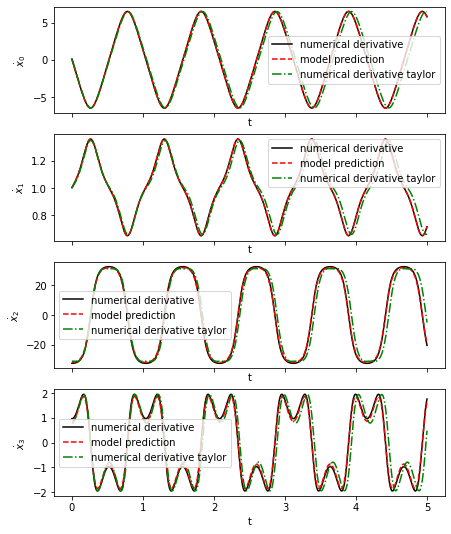

In [76]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)  

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)
x_dot_taylor_test_computed = model.differentiate(x_taylor_test, t=dt)
#t_test = np.linspace(0, 15, 3000)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    # taylor
    axs[i].plot(t_test, x_dot_taylor_test_computed[:, i],
                'g-.', label='numerical derivative taylor')

    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

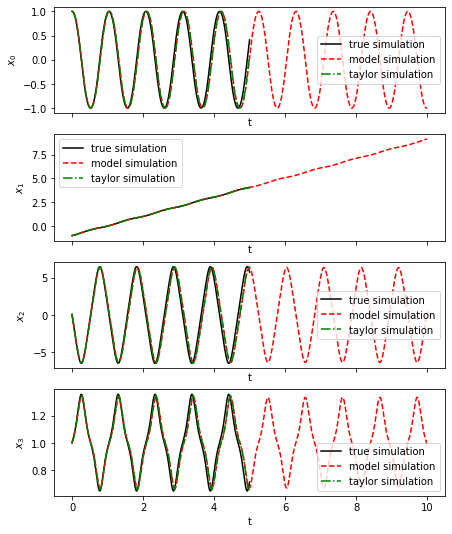

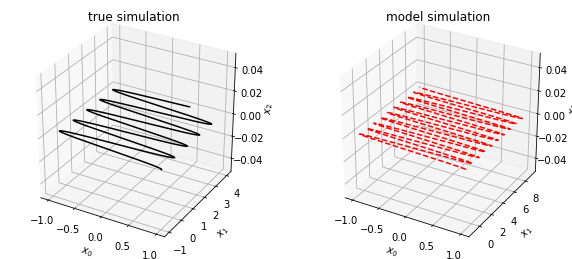

In [77]:
# Evolve the new initial condition in time with the SINDy model
#x0_test = [1,-1,0,1]
t_evolve = np.linspace(0, 10, 2000)
x_test_sim = model.simulate(x0_test, t_evolve)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i], 'k', label='true simulation')
    axs[i].plot(t_evolve, x_test_sim[:, i], 'r--', label='model simulation')
    # taylor
    axs[i].plot(t_test, x_taylor_test[:, i], 'g-.', label='taylor simulation')

    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$x_{}$'.format(i))

fig = plt.figure(figsize=(10, 4.5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_test[:, 0], x_test[:, 1],  'k')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test_sim[:, 0], x_test_sim[:, 1], 'r--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

fig.show()

Wall time: 48 ms
[[ 1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.99591281e-01  1.00001206e+00 -1.63321414e-01  4.82223379e-03]
 [ 9.98365208e-01  1.00004830e+00 -3.26609485e-01  9.66186495e-03]
 ...
 [ 3.71277282e-01  1.02614103e+00  5.88955140e+00 -2.99727341e-01]
 [ 4.00512031e-01  1.02466191e+00  5.79167287e+00 -2.91265886e-01]
 [ 4.29242494e-01  1.02322603e+00  5.68810431e+00 -2.82460082e-01]]


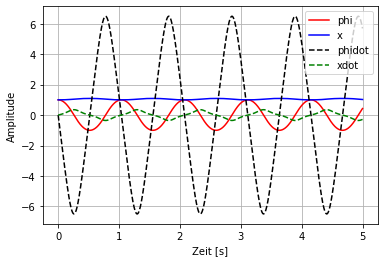

In [78]:
g = 9.81
s2 = 0.26890449

system_read = pickle.load(open("wagen_pendel_f.p","rb"))
%time rhs = system_read.create_simfunction()
t_ori_model = np.linspace(0, 5, 1000)
x0_ori_model = [1,1,0,0]

ori_model_data = odeint(rhs, x0_ori_model, t_ori_model)
print(ori_model_data)



plt.plot(t_ori_model, ori_model_data[:,0], color= 'red', label="phi")
plt.plot(t_ori_model, ori_model_data[:,1], color= 'blue', label="x")
plt.plot(t_ori_model, ori_model_data[:,2], color= 'black', linestyle='dashed', label="phidot")
plt.plot(t_ori_model, ori_model_data[:,3], color= 'green', linestyle='dashed', label="xdot")
plt.xlabel('Zeit [s]')
plt.ylabel('Amplitude')

plt.grid()
plt.legend()
plt.show()